In [1]:
import tensorflow as tf
import os
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt

C:\Users\91896\AppData\Local\Temp\ipykernel_4372\183779410.py:4: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [2]:
#To create augmented dataset and store it locally
#DONOT RUN THIS NOW THAT THE AUGMENTED DATASET HAS ALREADY BEEN CREATED
ans=input("Are you sure you want to run this(y/n): ")
if(ans=="y"): 
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    datagen = ImageDataGenerator(
            rotation_range=45,     
            width_shift_range=0.2,   
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest')

    i = 0
    for batch in datagen.flow_from_directory(directory="pepe_folder", 
                                             batch_size=20,  
                                             target_size=(256, 256),
                                             color_mode="rgb",
                                             save_to_dir=r'data\aug_pepe', 
                                             save_prefix='aug', 
                                             save_format='png'):
        i += 1
        if i > 60:
            break

    i = 0
    for batch in datagen.flow_from_directory(directory="notpepe_folder", 
                                             batch_size=20,  
                                             target_size=(256, 256),
                                             color_mode="rgb",
                                             save_to_dir=r'data\aug_notpepe', 
                                             save_prefix='aug', 
                                             save_format='png'):
        i += 1
        if i > 60:
            break

Are you sure you want to run this(y/n): n


In [3]:
#to retrieve augmented dataset and remove corrupted files from it
data_dir = 'data' 
image_exts = ['jpeg','jpg', 'bmp', 'png']
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))

In [4]:
predata = tf.keras.utils.image_dataset_from_directory('data')

Found 2892 files belonging to 2 classes.


In [5]:
data_iterator = predata.as_numpy_iterator()
batch = data_iterator.next()

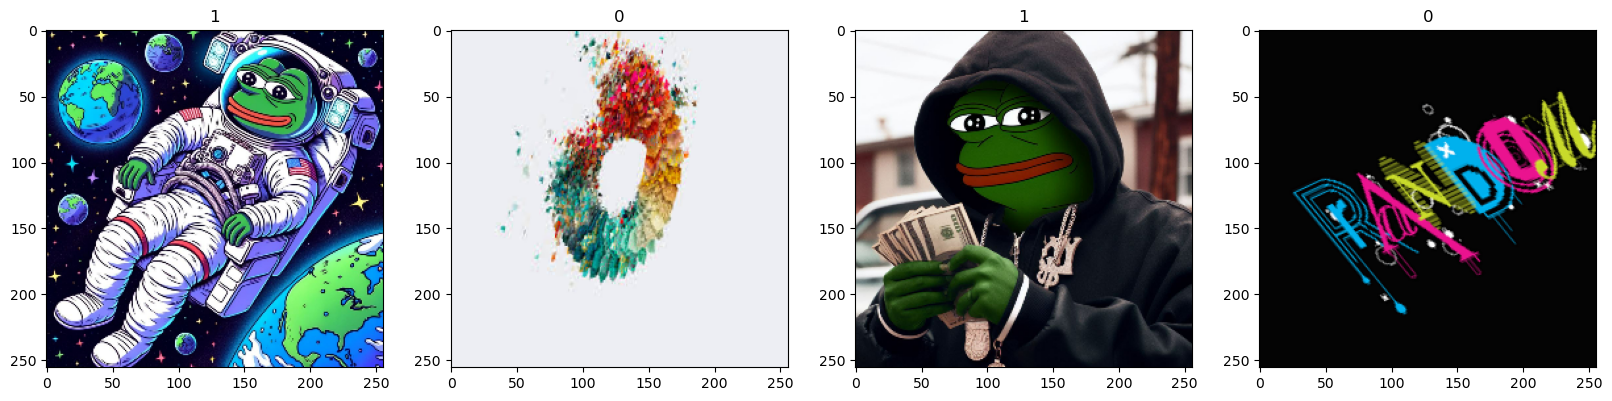

In [6]:
#to view a sample batch and verify the labels
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])


In [7]:
#scaling the images
data = predata.map(lambda x,y: (x/255, y))

In [8]:
#splitting the dataset into training, validation and testing
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten,BatchNormalization,Input

In [10]:
#building the model architecture
model = Sequential()
model.add(Input(shape=(256, 256, 3)))
model.add(Conv2D(16, (3, 3), strides=1, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(Conv2D(32, (3, 3), strides=1, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(Conv2D(16, (3, 3), strides=1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

from tensorflow.keras.optimizers import Adam

learning_rate = 0.0006
optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [11]:
#to view the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 254, 254, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 125, 125, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       3,686,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,696,817 (14.10 MB)

 Trainable params: 3,696,721 (14.10 MB)

 Non-trainable params: 96 (384.00 B)

In [12]:
#saving logs
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])


Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.9122 - loss: 0.2150 - val_accuracy: 0.4507 - val_loss: 1.8047
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.9297 - loss: 0.1771 - val_accuracy: 0.4951 - val_loss: 1.3680
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.9561 - loss: 0.1150 - val_accuracy: 0.6480 - val_loss: 0.9448
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.9714 - loss: 0.0847 - val_accuracy: 0.8520 - val_loss: 0.3252
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.9718 - loss: 0.0817 - val_accuracy: 0.8043 - val_loss: 0.5065
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.9928 - loss: 0.0311 - val_accuracy: 0.8668 - val_loss: 0.3785
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.9986 - loss: 0.0165 - val_accuracy: 0.9128 - val_loss: 0.2587
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.9997 - loss: 0.0110 - val_accuracy: 0.9342 - val_loss:

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [ ]:
#calculating precision, recall and binary accuracy
pre = Precision()
re = Recall()
acc = BinaryAccuracy()
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
print(pre.result(), re.result(), acc.result())

In [ ]:
#calculating the F1 score and test accuracy
from sklearn.metrics import f1_score
test_images = []
test_labels = []

for image, label in test:
    test_images.append(image)
    test_labels.append(label)

test_images = tf.concat(test_images, axis=0)
test_labels = tf.concat(test_labels, axis=0)


y_pred = model.predict(test_images)
y_pred_binary = (y_pred > 0.5).astype(int)  
y_true = test_labels  


f1 = f1_score(y_true, y_pred_binary)

print("F1 Score:", f1)
test_loss = model.evaluate(test)
print("Test Loss:", test_loss)

In [ ]:
#plotting the losses
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='Training Loss')
plt.plot(hist.history['val_loss'], color='orange', label='Validation Loss')


plt.axhline(y=test_loss[0], color='red', linestyle='--', label='Test Loss')

fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
for i in range(13):
    img = cv2.imread(f"C:/Users/91896/Desktop/not/OIP ({i}).jpeg")
    plt.imshow(img)
    resize = tf.image.resize(img, (256,256))
    plt.imshow(resize.numpy().astype(int))
    plt.show()
    yhat = model.predict(np.expand_dims(resize/255, 0))
    yhat
    if yhat > 0.5: 
        print(f'Pepe Found')
    else:
        print(f'Pepe Not Found')

In [ ]:
from tensorflow.keras.models import load_model

# Saving the model
model.save('imageclassifier.keras')